In [1]:
import pandas as pd  # requires: pip install pandas
import torch
import numpy as np
import matplotlib.pyplot as plt
from chronos import ChronosPipeline

In [4]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

In [51]:
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# The original Chronos models generate forecast samples, so forecast has shape
# [num_series, num_samples, prediction_length].
# Chronos-Bolt models generate quantile forecasts, so forecast has shape
# [num_series, num_quantiles, prediction_length].
forecast = pipeline.predict(
    context=torch.tensor(df["#Passengers"]), prediction_length=20 #Specifies that the model should predict the next 12 time steps.
) 

In [6]:
df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [7]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [8]:
df.shape

(144, 2)

### Data Exploration 

In [15]:
df['#Passengers'].mean()

280.2986111111111

<Axes: xlabel='#Passengers', ylabel='Count'>

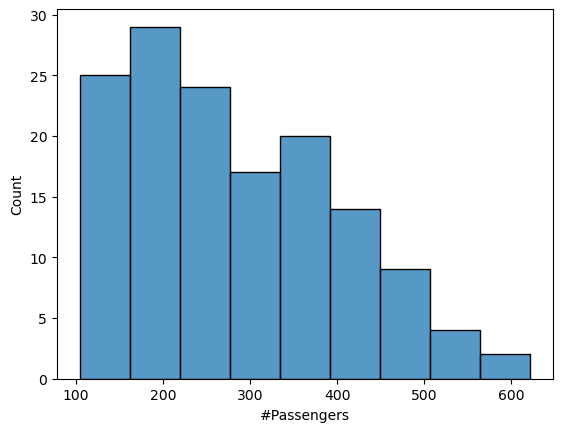

In [17]:
import seaborn as sns
sns.histplot(df['#Passengers'])#,kde = True, bins=50)

In [19]:
'''
Deviate from the normal distribution.
Have appreciable positive skewness.
Show peakedness.
'''
#skewness and kurtosis
print("Skewness: %f" % df['#Passengers'].skew())
print("Kurtosis: %f" % df['#Passengers'].kurt()) # positive show long tail , negative light tail

Skewness: 0.583160
Kurtosis: -0.364942


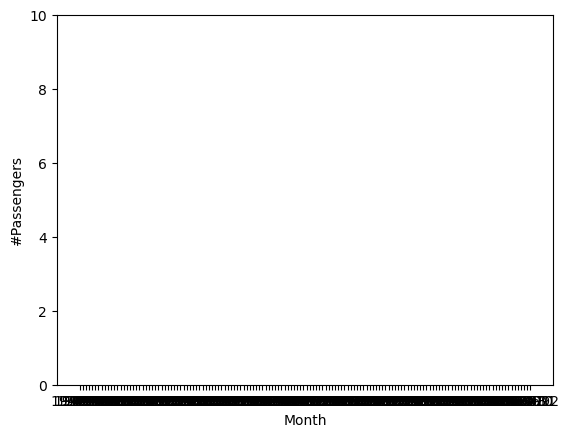

In [24]:
var = 'Month'
data = pd.concat([df['#Passengers'], df[var]], axis=1)
data.plot.scatter(x=var, y='#Passengers', ylim=(0,10)); # do not `assume here any thing this is just examples
plt.show() # Display

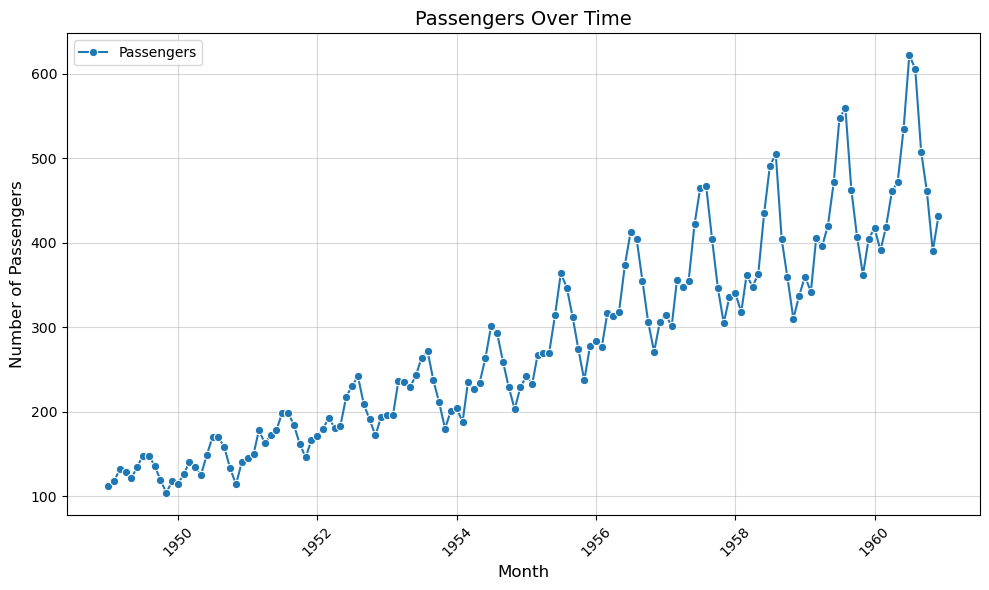

In [30]:
df['Month'] = pd.to_datetime(df['Month'])
# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Month', y='#Passengers', marker='o', label='Passengers')

# Add labels, title, and legend
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.title('Passengers Over Time', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.legend()
plt.grid(alpha=0.5)  # Add a light grid
plt.tight_layout()
plt.show()

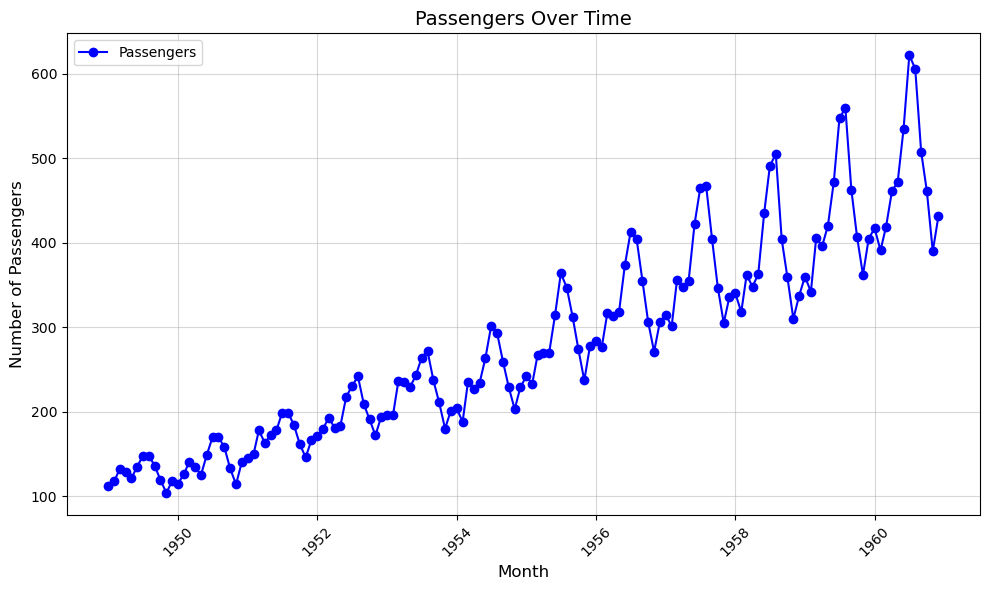

In [29]:
import matplotlib.pyplot as plt
df['Month'] = pd.to_datetime(df['Month']) # To see the time beter, in a range
# Plot data as a line plot
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(df['Month'], df['#Passengers'], marker='o', linestyle='-', color='b', label='Passengers')

# Add labels, title, and legend
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.title('Passengers Over Time', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend()
plt.grid(alpha=0.5)  # Add a light grid
plt.tight_layout()   # Adjust layout to prevent overlap
plt.show()

In [31]:
print(df.dtypes)

Month          datetime64[ns]
#Passengers             int64
dtype: object


In [32]:
correlation_matrix = df.select_dtypes(include=['float64', 'int64']).corr()
print(correlation_matrix)

             #Passengers
#Passengers          1.0


In [33]:
df['Month_ordinal'] = df['Month'].map(lambda x: x.toordinal())
correlation_matrix = df.corr()
print(correlation_matrix)

                  Month  #Passengers  Month_ordinal
Month          1.000000     0.923853       1.000000
#Passengers    0.923853     1.000000       0.923853
Month_ordinal  1.000000     0.923853       1.000000


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Month          144 non-null    datetime64[ns]
 1   #Passengers    144 non-null    int64         
 2   Month_ordinal  144 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 3.5 KB


In [35]:
# Convert 'Month' to datetime
df['Month'] = pd.to_datetime(df['Month'])

# (Optional) Create an ordinal representation of 'Month'
df['Month_ordinal'] = df['Month'].map(lambda x: x.toordinal())

# Calculate correlation excluding non-numeric columns
correlation_matrix = df.select_dtypes(include=['float64', 'int64']).corr()
print(correlation_matrix)

               #Passengers  Month_ordinal
#Passengers       1.000000       0.923853
Month_ordinal     0.923853       1.000000


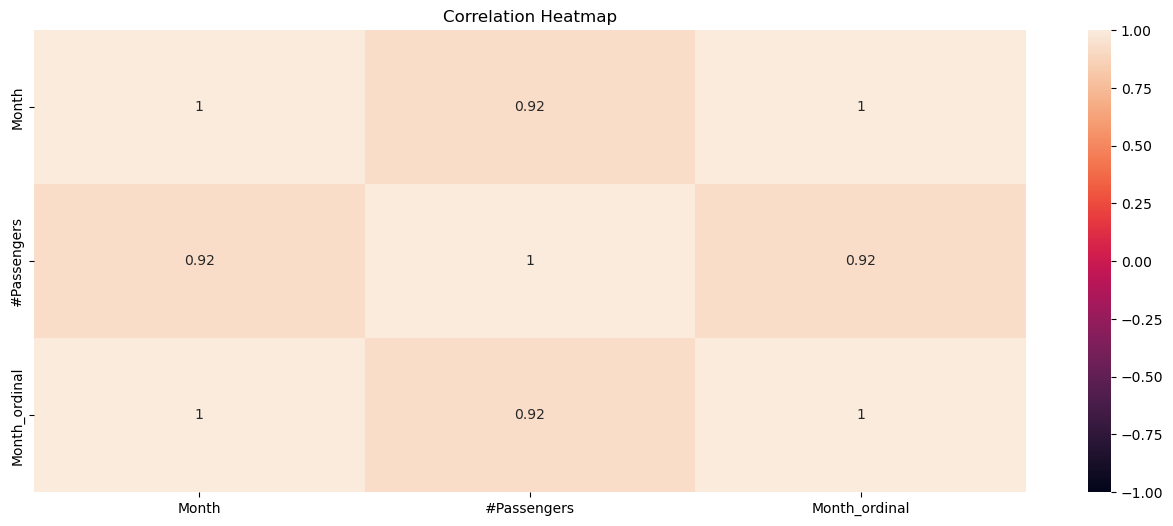

In [36]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

plt.show()  # Display the heatmap

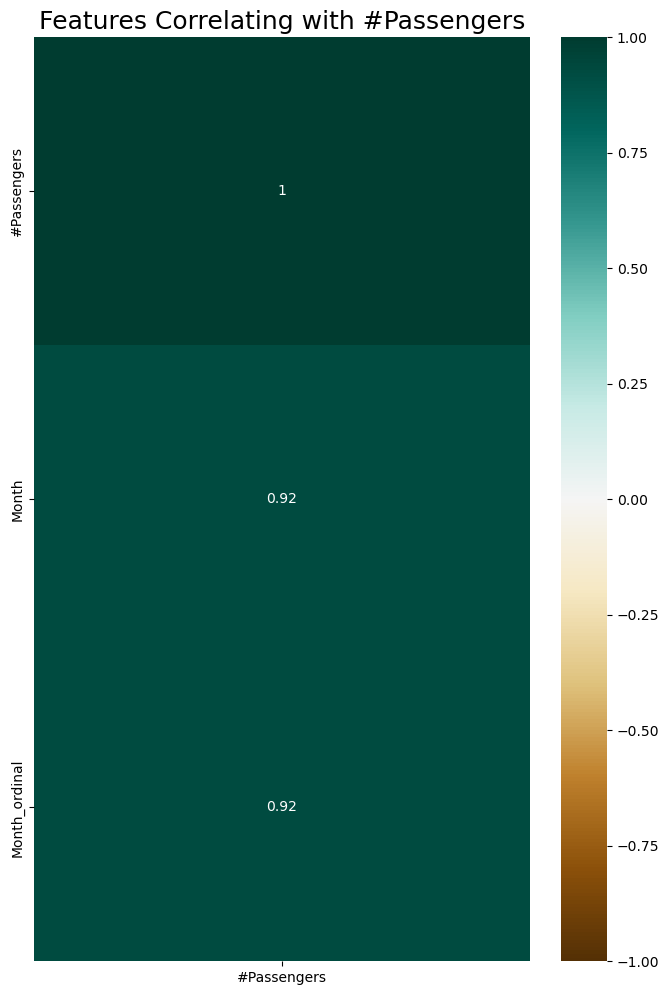

In [38]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['#Passengers']].sort_values(by='#Passengers', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with #Passengers', fontdict={'fontsize':18});
plt.show()

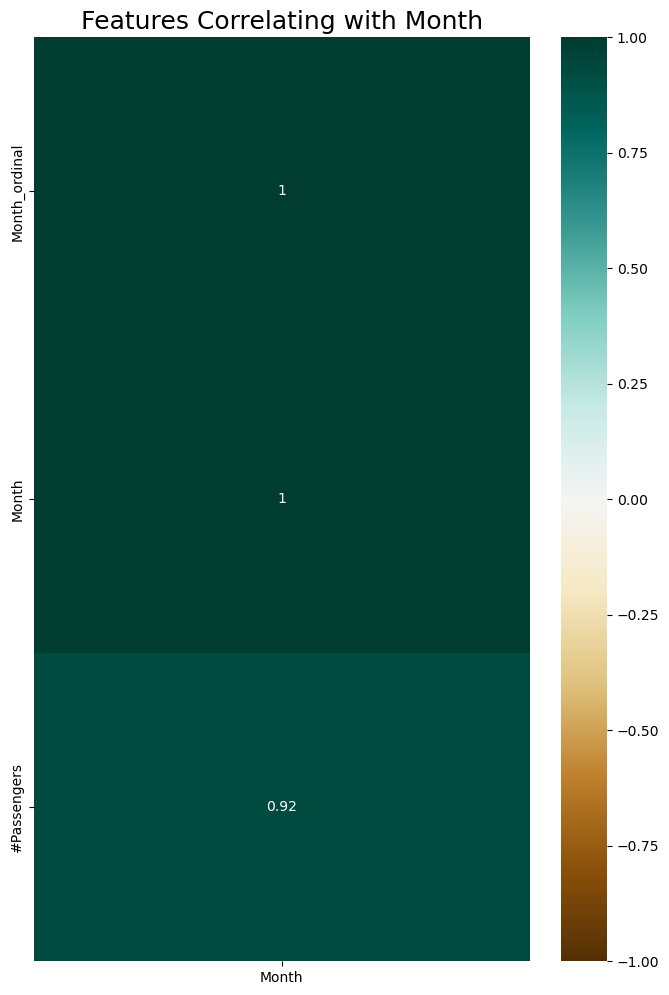

In [40]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['Month']].sort_values(by='Month', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Month', fontdict={'fontsize':18});
plt.show()

## Back to classification practice

In [41]:
len(df)

144

In [42]:
forcast_index = range(len(df), len(df) + 12)

In [43]:
from chronos import ChronosPipeline, ChronosBoltPipeline

print(ChronosPipeline.predict.__doc__)  # for Chronos models
print(ChronosBoltPipeline.predict.__doc__)  # for Chronos-Bolt models


        Get forecasts for the given time series.

        Refer to the base method (``BaseChronosPipeline.predict``)
        for details on shared parameters.

        Additional parameters
        ---------------------
        num_samples
            Number of sample paths to predict. Defaults to what
            specified in ``self.model.config``.
        temperature
            Temperature to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_k
            Top-k parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_p
            Top-p parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        limit_prediction_length
            Force prediction length smaller or equal than the
            built-in prediction length from the model. False by
            default. When true, fail loudly if longer p

In [52]:
forecast_index = range(len(df), len(df) + 20)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

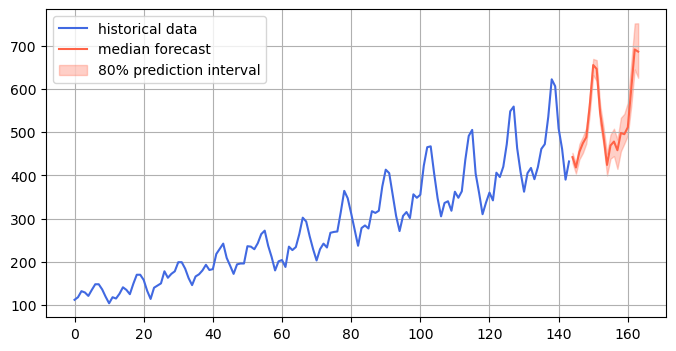

In [53]:
# Ploting
plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()